In [1]:
import underworld as uw
from underworld import function as fn
import glucifer
import numpy as np
import math

In [2]:
from planetengine.utilities import quickShow

In [3]:
mesh = uw.mesh.FeMesh_Annulus(
    elementRes = (64, 64),
    radialLengths = (1., 2.),
    angularExtent = (70., 110.),
    periodic = [False, False],
    )

In [4]:
temperatureField = uw.mesh.MeshVariable(mesh, 1)
temperatureDotField = uw.mesh.MeshVariable(mesh, 1)
pressureField = uw.mesh.MeshVariable(mesh.subMesh, 1)
velocityField = uw.mesh.MeshVariable(mesh, 2)

In [5]:
inner = mesh.specialSets["inner"]
outer = mesh.specialSets["outer"]
sides = mesh.specialSets["MaxJ_VertexSet"] + mesh.specialSets["MinJ_VertexSet"]

velBC = uw.conditions.RotatedDirichletCondition(
    variable = velocityField,
    indexSetsPerDof= (inner + outer, sides),
    basis_vectors = (mesh.bnd_vec_normal, mesh.bnd_vec_tangent)
    )

tempBC = uw.conditions.DirichletCondition(
    variable = temperatureField,
    indexSetsPerDof = (inner + outer,)
    )

In [6]:
vc = uw.mesh.MeshVariable(mesh = mesh, nodeDofCount = 2)
vc_eqNum = uw.systems.sle.EqNumber(vc, False )
vcVec = uw.systems.sle.SolutionVector(vc, vc_eqNum)

In [7]:
isoviscous = fn.misc.constant(True)

invDensityFn = temperatureField * 1e7
buoyancyFn = invDensityFn * mesh.unitvec_r_Fn
magnitude = fn.math.sqrt(fn.coord()[0]**2 + fn.coord()[1]**2)
depthFn = mesh.radialLengths[1] - magnitude
yieldStressFn = 4e5 + (1e7 * depthFn)
secInvFn = fn.tensor.second_invariant(fn.tensor.symmetric(vc.fn_gradient))
plasticViscFn = yieldStressFn / (2. * secInvFn + 1e-18)
creepViscFn = fn.math.pow(fn.misc.constant(3e4), -1. * (temperatureField - 1.))
viscoplastic = fn.misc.min(3e4, fn.misc.max(1., fn.misc.min(creepViscFn, plasticViscFn)))

viscosityFn = fn.branching.conditional([(isoviscous, 1.), (True, viscoplastic)])

stokes = uw.systems.Stokes(
    velocityField = velocityField,
    pressureField = pressureField,
    conditions = [velBC,],
    fn_viscosity = viscosityFn + 0. * velocityField[0],
    fn_bodyforce = buoyancyFn,
    _removeBCs = False,
    )

solver = uw.systems.Solver(stokes)

In [8]:
def postSolve():
    # realign solution using the rotation matrix on stokes
    uw.libUnderworld.Underworld.AXequalsY(
        stokes._rot._cself,
        stokes._velocitySol._cself,
        vcVec._cself,
        False
        )
    # remove null space - the solid body rotation velocity contribution
    uw.libUnderworld.StgFEM.SolutionVector_RemoveVectorSpace(
        stokes._velocitySol._cself, 
        stokes._vnsVec._cself
        )

In [9]:
def solve():
    velocityField.data[:] = 0.
    solver.solve(
        nonLinearIterate = not isoviscous.value,
        callback_post_solve = postSolve
        )
    uw.libUnderworld.Underworld.AXequalsX(
        stokes._rot._cself,
        stokes._velocitySol._cself,
        False
        )

In [10]:
class Sinusoidal:

    def __init__(
            self, variableArray, coordArray,
            pert = 0.2,
            freq = 1.,
            tempRange = (0., 1.),
            phase = 0.,
            boxDims = (1., 1.), # length, height
            ):
        self.variableArray = variableArray
        self.coordArray = coordArray
        self.freq = freq
        self.tempRange = tempRange
        self.phase = phase
        self.pert = pert
        self.boxDims = boxDims

    def sinusoidal_IC(self):
        boxLength, boxHeight = self.boxDims
        tempMin, tempMax = self.tempRange
        deltaT = self.tempRange[1] - self.tempRange[0]
        pertArray = \
            self.pert \
            * np.cos(np.pi * (self.phase + self.freq * self.coordArray[:,0])) \
            * np.sin(np.pi * self.coordArray[:,1])
        outArray = tempMin + deltaT * (boxHeight - self.coordArray[:,1]) + pertArray
        outArray = np.clip(outArray, tempMin, tempMax)
        outArray = np.array([[item] for item in outArray])
        return outArray

    def apply(self):
        self.variableArray[:] = self.sinusoidal_IC()

In [11]:
class Radial:

    def __init__(
            self,
            radialLengths = (0., 1.),
            angularExtent = (0., 360.),
            boxDims = ((0., 1.), (0., 1.)),
            origin = (0., 0.),
            xFlip = True,
            ):
        # angular extents must be given in degrees
        self.radialLengths = radialLengths
        self.angularExtent = angularExtent
        self.boxDims = boxDims
        self.origin = origin

    def recentered_coords(self, coordArray):
        recenteredCoords = coordArray - self.origin
        return recenteredCoords

    def radial_coords(self, coordArray):
        recenteredCoords = self.recentered_coords(coordArray)
        xs, ys = recenteredCoords.transpose()
        angular = np.arctan2(ys, xs) * 180. / np.pi
        radial = np.hypot(xs, ys)
        radialCoords = np.dstack((angular, radial))[0]
        return radialCoords

    def curved_box(self, coordArray):
        radInScale = self.radialLengths
        angOffset = self.angularExtent[0] // 360. * 360. 
        angInScale = tuple([x - angOffset for x in self.angularExtent])
        angOutScale, radOutScale = self.boxDims
        radialCoords = self.radial_coords(coordArray)
        xs, ys = radialCoords.transpose()
        xs = np.where(xs >= 0., xs, xs + 360.)
        xs += (angOutScale[0] - angInScale[0])
        xs *= (angOutScale[1] - angOutScale[0]) / (angInScale[1] - angInScale[0])
        xs -= (angOutScale[1])
        xs *= -1.
        xs = np.clip(xs, angOutScale[0], angOutScale[1])
        ys += radOutScale[0] - radInScale[0]
        ys *= (radOutScale[1] - radOutScale[0]) / (radInScale[1] - radInScale[0])
        ys = np.clip(ys, radOutScale[0], radOutScale[1])
        curvedBox = np.dstack([xs, ys])[0]

        return curvedBox

In [12]:
curvedBox = Radial(
    mesh.radialLengths,
    mesh.angularExtent,
    boxDims = ((0., 1.), (0., 1.))
    ).curved_box

In [13]:
def initialise():
    tempFn = Sinusoidal(temperatureField.data, curvedBox(mesh.data))
    tempFn.apply()
    temperatureField.data[outer] = 0.
    temperatureField.data[inner] = 1.
    velocityField.data[:] = [0., 0.]
    pressureField.data[:] = 0.
    temperatureDotField.data[:] = 0.

In [14]:
initialise()


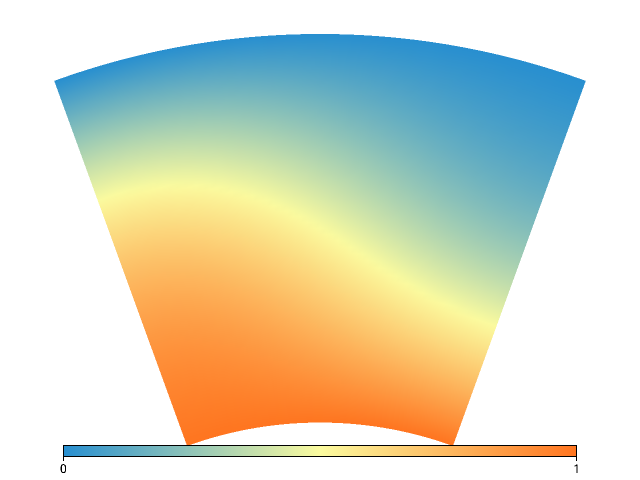

In [15]:
quickShow(temperatureField)

In [16]:
def test(isovisc):
    isoviscous.value = isovisc
    print("Isoviscous: ", isovisc)
    initialise()
    solve()
    velCopy = velocityField.data.copy()
    solve()
    return(velCopy, velocityField.data)
    #print("Vel field unchanged: ", (velCopy, velocityField.data))

In [17]:
velCopy, newVel = test(True)
np.mean(velCopy / newVel)

Isoviscous:  True


1.0

In [18]:
velCopy, newVel = test(False)
np.mean(velCopy / newVel)

Isoviscous:  False


0.96868446986212575